In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle

awkward version  1.10.1
coffea version  0.7.19


In [2]:
#fff = uproot.open(infiles[0])

In [3]:
#fff["Events"]

In [4]:
#fff["Events"].keys()

In [5]:
#np.abs(pdgid.array()) == 11

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from response_maker_nanov9_lib import *
from response_maker_nanov9 import main

In [8]:
! mv qjetmass_zjets.pkl qjetmass_zjets_old.pkl

In [9]:
#! rm qjetmass_zjets.pkl

In [41]:
main(testing=False)

Output()

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.p

In [42]:
with open("qjetmass_zjets.pkl", "rb") as f:
    output = pickle.load( f )

In [43]:
output.keys()

dict_keys(['njet_gen', 'njet_reco', 'ptjet_gen', 'ptjet_reco', 'ptjet_reco_over_gen', 'drjet_reco_gen', 'mz_gen', 'mz_reco', 'mz_reco_over_gen', 'dr_z_jet_gen', 'dr_z_jet_reco', 'dphi_z_jet_gen', 'dphi_z_jet_reco', 'ptasym_z_jet_gen', 'ptasym_z_jet_reco', 'm_u_jet_reco_over_gen', 'm_g_jet_reco_over_gen', 'dr_gen_subjet', 'response_matrix_u', 'response_matrix_g', 'cutflow'])

In [44]:
output["cutflow"]

{'UL18NanoAOD2500toInf': defaultdict(int,
             {'ee total': 2308156,
              'ee nlep >=2': 348657,
              'ee zpt > 90': 319789,
              'ee >=1 gen jet': 301133,
              'ee gen jet pt cut': 301133,
              'ee gen jet eta cut': 301133,
              'ee gen jet dphi cut': 286986,
              'ee gen jet asym cut': 21148,
              'ee gen jet cuts': 21148,
              'ee groomed gen jet cuts ': 21148,
              'ee >=1 reco jet': 18632,
              'ee reco jet cuts': 18632,
              'mm total': 2395518,
              'mm nlep >=2': 439174,
              'mm zpt > 90': 369935,
              'mm >=1 gen jet': 348121,
              'mm gen jet pt cut': 348121,
              'mm gen jet eta cut': 348121,
              'mm gen jet dphi cut': 330329,
              'mm gen jet asym cut': 21914,
              'mm gen jet cuts': 21914,
              'mm groomed gen jet cuts ': 21914,
              'mm >=1 reco jet': 21774,
         

In [45]:
import matplotlib.pyplot as plt

In [46]:
output.keys()

dict_keys(['njet_gen', 'njet_reco', 'ptjet_gen', 'ptjet_reco', 'ptjet_reco_over_gen', 'drjet_reco_gen', 'mz_gen', 'mz_reco', 'mz_reco_over_gen', 'dr_z_jet_gen', 'dr_z_jet_reco', 'dphi_z_jet_gen', 'dphi_z_jet_reco', 'ptasym_z_jet_gen', 'ptasym_z_jet_reco', 'm_u_jet_reco_over_gen', 'm_g_jet_reco_over_gen', 'dr_gen_subjet', 'response_matrix_u', 'response_matrix_g', 'cutflow'])

In [47]:
response_matrix_u_values = output['response_matrix_u'].values()
response_matrix_g_values = output['response_matrix_g'].values()

In [48]:
ndatasets = response_matrix_u_values.shape[0]

In [49]:
norm = np.sum( response_matrix_u_values, axis=(1,2,3,4,5) )
for i in range(ndatasets):    
    if norm[i] > 0:
        response_matrix_u_values[i,:,:,:,:,:] /= norm[i]

In [50]:
response_matrix_u_summed = np.sum( response_matrix_u_values, axis=(0,1))
print(response_matrix_u_summed.shape)
nptreco,nmassreco,nptgen,nmassgen = response_matrix_u_summed.shape
response_matrix_u_final = response_matrix_u_summed.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) )

(7, 13, 7, 25)


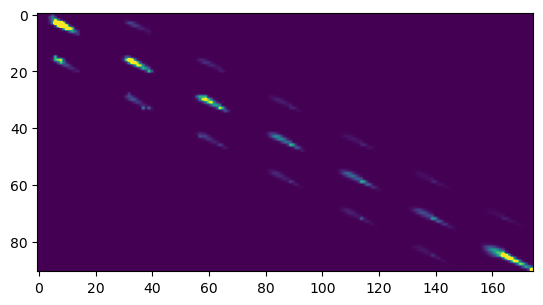

In [90]:
plt.imshow( np.log(response_matrix_u_final+1), vmax=0.2 )

In [52]:
norm = np.sum( response_matrix_g_values, axis=(1,2,3,4,5) )
for i in range(ndatasets):    
    if norm[i] > 0:
        response_matrix_g_values[i,:,:,:,:,:] /= norm[i]

In [53]:
response_matrix_g_summed = np.sum( response_matrix_g_values, axis=(0,1))
print(response_matrix_g_summed.shape)
nptreco,nmassreco,nptgen,nmassgen = response_matrix_g_summed.shape
response_matrix_g_final = response_matrix_g_summed.reshape( (nptreco)*(nmassreco), (nptgen)*(nmassgen) )

(7, 13, 7, 25)


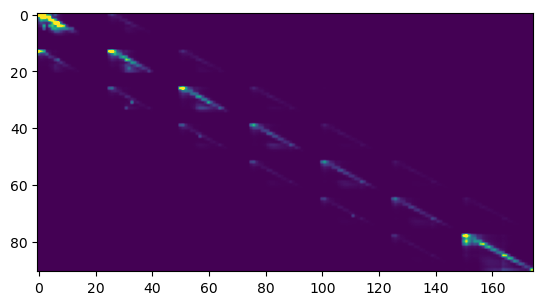

In [89]:
plt.imshow( np.log(response_matrix_g_final+1), vmax=0.2 )

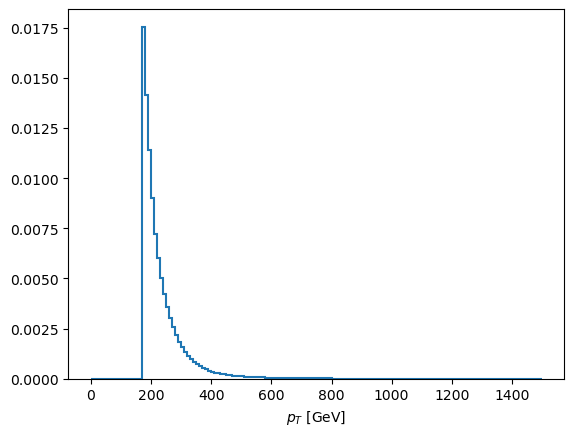

In [55]:
output['ptjet_gen'].project("pt").plot(density=True)
plt.show()

In [56]:
output['ptjet_gen'].sum().value

201664.93143339473

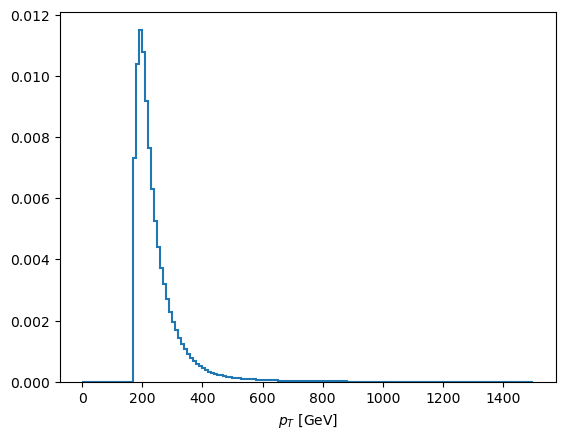

In [57]:
output['ptjet_reco'].project("pt").plot(density=True)
plt.show()

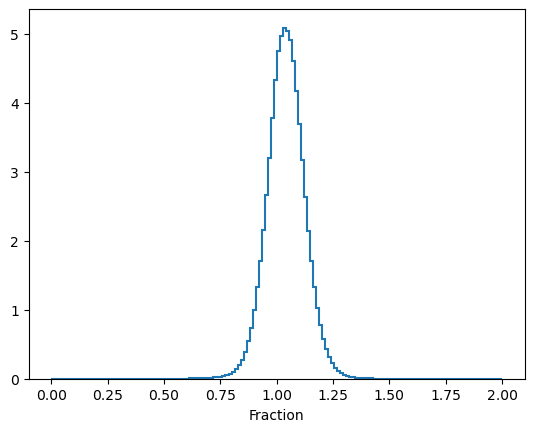

In [58]:
output['ptjet_reco_over_gen'].project("frac").plot(density=True)
plt.show()

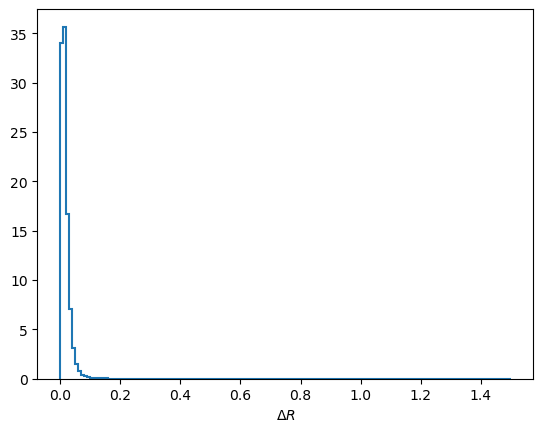

In [59]:
output['drjet_reco_gen'].project("dr").plot(density=True)
plt.show()

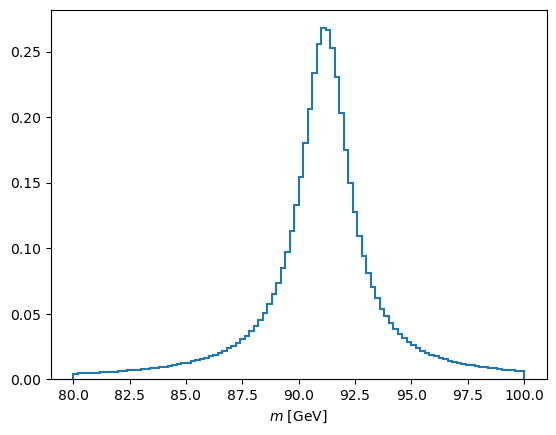

In [60]:
output['mz_gen'].project("mass").plot(density=True)
plt.show()

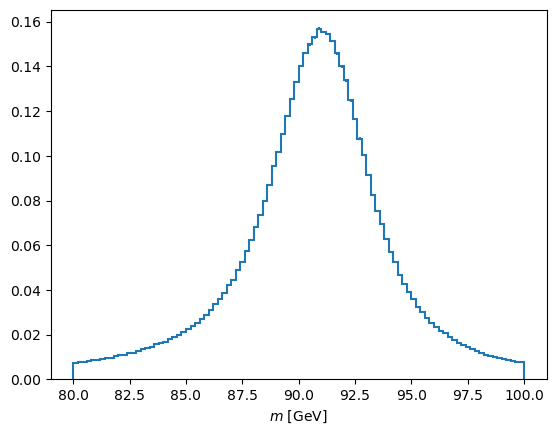

In [61]:
output['mz_reco'].project("mass").plot(density=True)
plt.show()

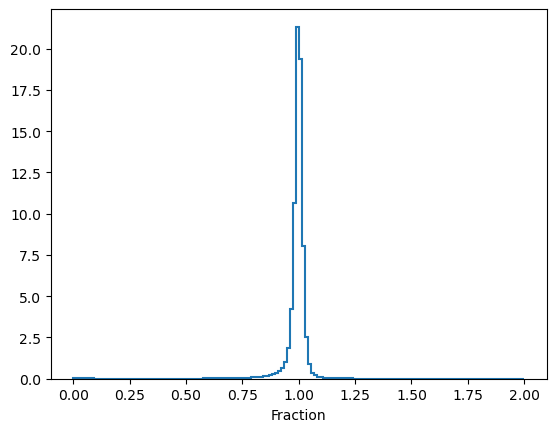

In [62]:
output['mz_reco_over_gen'].project("frac").plot(density=True)
plt.show()

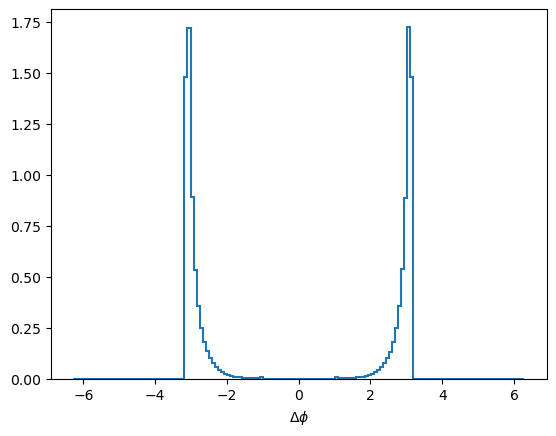

In [63]:
output['dphi_z_jet_gen'].project("dphi").plot(density=True)
plt.show()

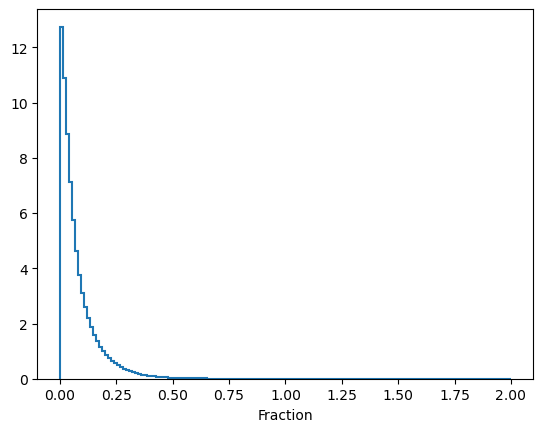

In [64]:
output['ptasym_z_jet_gen'].project("frac").plot(density=True)
plt.show()

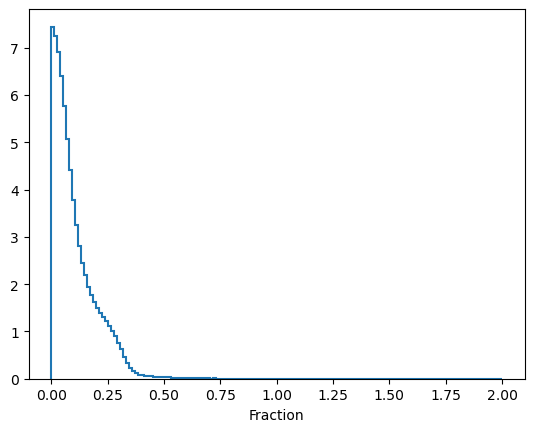

In [65]:
output['ptasym_z_jet_reco'].project("frac").plot(density=True)
plt.show()

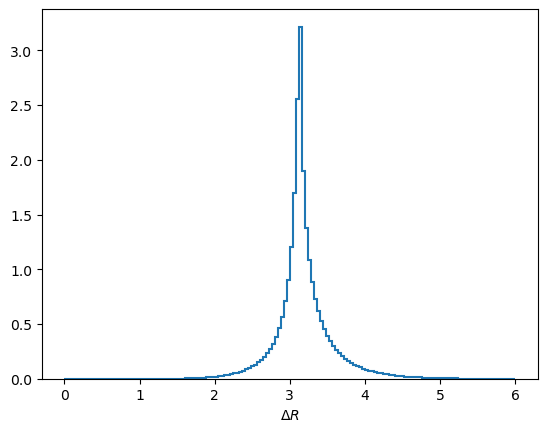

In [66]:
output['dr_z_jet_gen'].project("dr").plot(density=True)
plt.show()

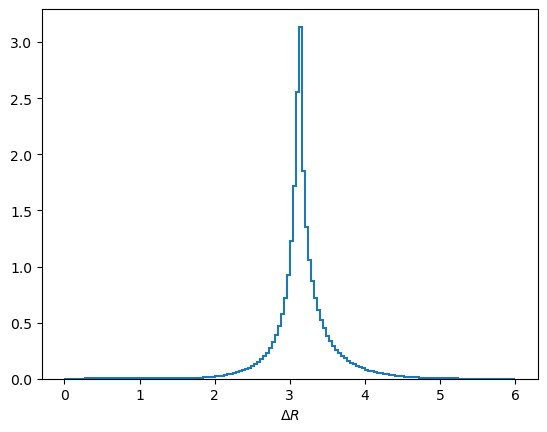

In [67]:
output['dr_z_jet_reco'].project("dr").plot(density=True)
plt.show()

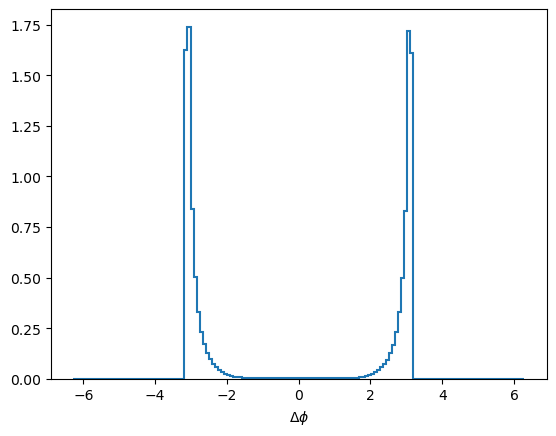

In [68]:
output['dphi_z_jet_reco'].project("dphi").plot(density=True)
plt.show()

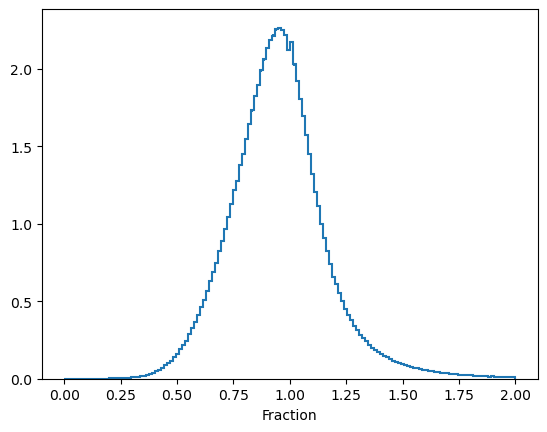

In [69]:
output['m_u_jet_reco_over_gen'].project("frac").plot(density=True)
plt.show()

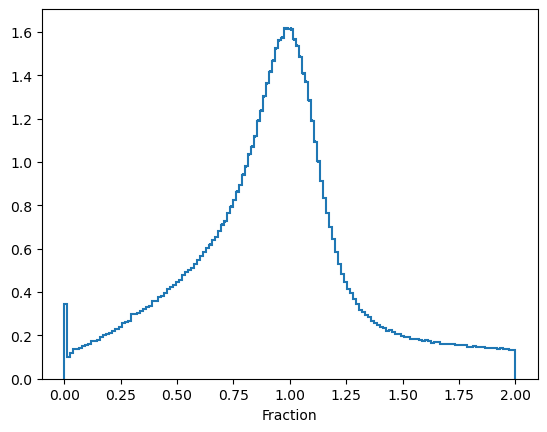

In [70]:
output['m_g_jet_reco_over_gen'].project("frac").plot(density=True)
plt.show()

In [74]:
output['m_g_jet_reco_over_gen']

Hist(
  StrCategory(['UL18NanoAOD2500toInf', 'UL18NanoAOD1200to2500', 'UL18NanoAOD800to1200', 'UL18NanoAOD600to800', 'UL18NanoAOD400to600', 'UL18NanoAOD200to400', 'UL18NanoAOD100to200', 'UL18NanoAOD70to100', 'UL17NanoAOD2500toInf', 'UL17NanoAOD1200to2500', 'UL17NanoAOD800to1200', 'UL17NanoAOD600to800', 'UL17NanoAOD400to600', 'UL17NanoAOD200to400', 'UL17NanoAOD100to200', 'UL17NanoAOD70to100', 'UL16NanoAODAPV2500toInf', 'UL16NanoAODAPV1200to2500', 'UL16NanoAODAPV800to1200', 'UL16NanoAODAPV600to800', 'UL16NanoAODAPV400to600', 'UL16NanoAODAPV200to400', 'UL16NanoAODAPV100to200', 'UL16NanoAODAPV70to100', 'UL16NanoAOD2500toInf', 'UL16NanoAOD1200to2500', 'UL16NanoAOD800to1200', 'UL16NanoAOD600to800', 'UL16NanoAOD400to600', 'UL16NanoAOD200to400', 'UL16NanoAOD100to200', 'UL16NanoAOD70to100'], growth=True, name='dataset', label='Primary dataset'),
  StrCategory(['ee', 'mm'], name='lep'),
  Regular(150, 0, 2, name='frac', label='Fraction'),
  storage=Weight()) # Sum: WeightedSum(value=106191, vari

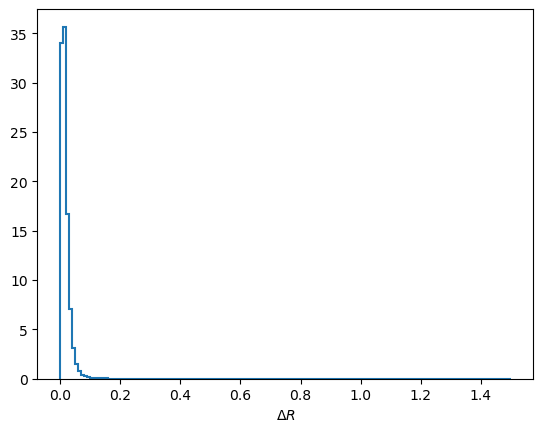

In [71]:
output['drjet_reco_gen'].project("dr").plot(density=True)
plt.show()

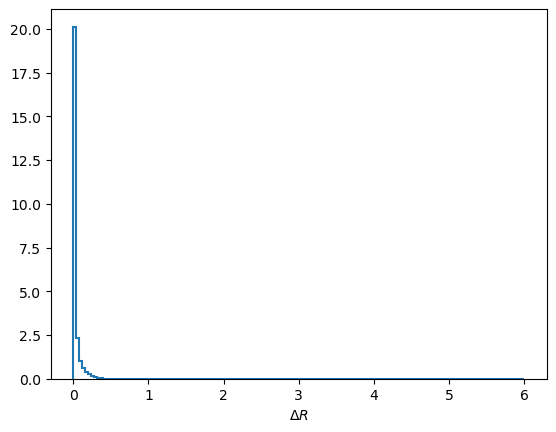

In [72]:
output['dr_gen_subjet'].project("dr").plot(density=True)
plt.show()